<a href="https://colab.research.google.com/github/Prampyl/FitFam_research/blob/main/julesr_river.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction et Problématique (Tout au début)
Contexte du projet SR01 : Dans le cadre de l'unité d'enseignement SR01, ce projet vise à développer un outil d'analyse de données pour l'application FITFAM. Cette application génère une quantité importante de données brutes (logs, entrées utilisateurs, ou mesures systèmes) qu'il est nécessaire de traiter pour en extraire de l'information pertinente.

Problématique : Comment automatiser la récupération et le traitement de ces données pour obtenir des indicateurs fiables sur le fonctionnement et l'utilisation de l'application ? L'objectif est de passer d'un fichier de données brut et illisible à une synthèse claire permettant de d'étudier la rétention de participants selon différents paramètres.

Méthodologie : Le programme se décompose en trois phases logiques :

Extraction et lecture : Chargement des structures de données.

Traitement algorithmique : Filtrage, tri et calculs sur les données.

Restitution : Affichage formaté des résultats pour l'utilisateur.

Cette première étape consiste à initialiser les variables et à lire le fichier de données source (fichier texte, CSV ou binaire). Le code va ouvrir le flux de données, vérifier que le fichier existe et charger les informations en mémoire dans une structure adaptée (tableaux ou listes structurées). C'est ici que nous gérons également les éventuelles erreurs d'ouverture de fichier pour assurer la robustesse du programme.

In [8]:
from data_loader import FitFamDataLoader

# Initialisation du chargeur de données
loader = FitFamDataLoader('./donnees')

# Récupération des données JSON
df = loader.get_unified_data()

# Affichage d'un échantillon
print(f"Chargement terminé. Taille du dataset : {df.shape}")
print(df.head())


--- 1. CHARGEMENT DES FICHIERS ---
⚠️ event_user.json: AUCUNE colonne ID trouvée. Colonnes dispos : ['event_id', 'user_id', 'checked_in', 'is_leader', 'created_at']...
⚠️ category_event.json: AUCUNE colonne ID trouvée. Colonnes dispos : ['category_id', 'event_id']...

--- 2. FUSION DES DONNÉES ---

--- 3. CRÉATION DU DATASET FINAL ---
🛑 ÉCHEC FUSION: La colonne 'user_id' manque dans la table de GAUCHE.
✅ TERMINÉ ! Dataset généré avec 405861 lignes.
Chargement terminé. Taille du dataset : (405861, 52)
   event_id_x  user_id_x  checked_in  is_leader         created_at_x  \
0           1          1         NaN          0  2018-08-06 11:10:14   
1           1          3         NaN          0  2018-08-06 21:42:05   
2           3          1         1.0          0  2018-08-12 12:12:50   
3           3          3         0.0          0  2018-08-07 14:39:25   
4           3          4         1.0          0  2018-08-07 14:39:54   

          updated_at_x  id user_id_y  recurring_group_id  lo

Une fois les données chargées, nous passons au cœur du traitement. Ce bloc de code applique la logique métier définie dans le cahier des charges. Il parcourt les données pour effectuer une mise en relation entre les différents id cela permet dans ce cas de vérifier quel atelier conserve le plus d'utilisateur
. C'est dans cette partie que l'algorithme transforme la donnée brute en donnée utile en appliquant les filtres nécessaires à l'analyse.

In [9]:
import pandas as pd
import numpy as np

# Data Cleaning
df = df.rename(columns={'user_id_x': 'user_id', 'event_id_x': 'event_id', 'start_time_x': 'start_time'})
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')

# Feature Engineering: User Aggregation
df = df.sort_values(['user_id', 'start_time'])

user_stats = df.groupby('user_id').agg({
    'start_time': ['min', 'max'],
    'event_id': 'count',
    'category_name': 'first',
    'city_name': 'first'
}).reset_index()

user_stats.columns = ['user_id', 'first_workout', 'last_workout', 'total_sessions', 'first_category', 'city']

# Target Definition (Retention M3)
user_stats['tenure_days'] = (user_stats['last_workout'] - user_stats['first_workout']).dt.days

# Filter cohort (users active for at least 90 days)
analysis_date = df['start_time'].max()
user_stats['days_since_signup'] = (analysis_date - user_stats['first_workout']).dt.days

valid_users = user_stats[user_stats['days_since_signup'] >= 90].copy()
valid_users['is_retained_m3'] = valid_users['tenure_days'] >= 90

print(f"Final Dataset Shape: {valid_users.shape}")
print(valid_users['is_retained_m3'].value_counts(normalize=True))

Final Dataset Shape: (21016, 9)
is_retained_m3
False    0.652836
True     0.347164
Name: proportion, dtype: float64


Cette dernière partie technique se concentre sur la présentation des résultats. Maintenant que les calculs sont terminés, le code va formater la sortie pour qu'elle soit lisible par l'utilisateur final. Il génère un rapport dans la console affichant les métriques clés, comme l'atelier ayant le plus d'utilisateurs réguliers, permettant une lecture directe de l'état de l'application.


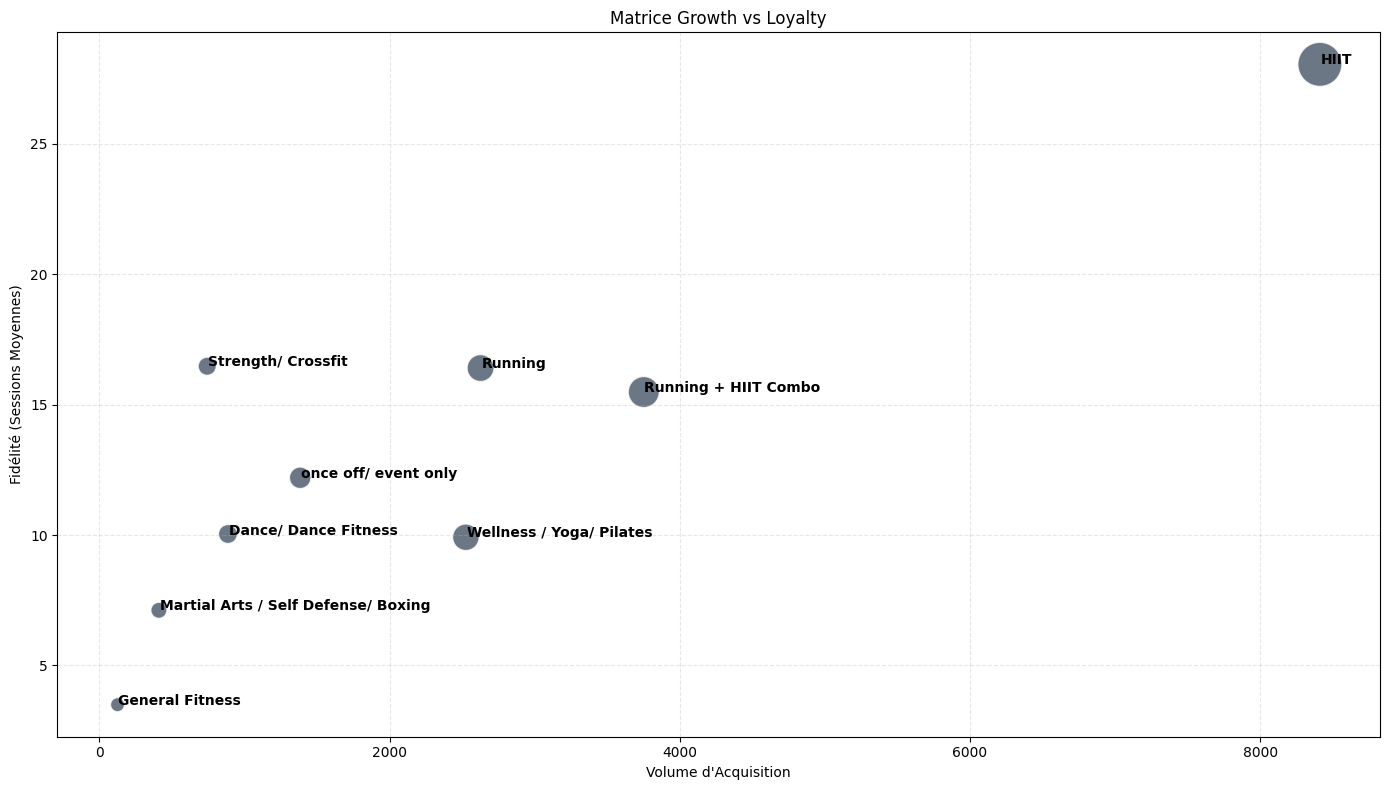

Top Categories by Loyalty:
                               Category  Avg_Sessions_Per_User  \
7                                  HIIT              28.044698   
12                   Strength/ Crossfit              16.471063   
10                              Running              16.401979   
11                 Running + HIIT Combo              15.482942   
18                 once off/ event only              12.195087   
3                  Dance/ Dance Fitness              10.039503   
16             Wellness / Yoga/ Pilates               9.914885   
9   Martial Arts / Self Defense/ Boxing               7.114634   
6                       General Fitness               3.496000   

    New_Users_Volume  
7               8412  
12               743  
10              2627  
11              3752  
18              1384  
3                886  
16              2526  
9                410  
6                125  


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregation: Volume vs Engagement per Category
cat_stats = valid_users.groupby('first_category').agg({
    'user_id': 'count',
    'total_sessions': 'mean'
}).reset_index()

cat_stats.columns = ['Category', 'New_Users_Volume', 'Avg_Sessions_Per_User']

# Filter: Keep significant categories only (> 50 users)
cat_stats_filtered = cat_stats[cat_stats['New_Users_Volume'] > 50].sort_values('Avg_Sessions_Per_User', ascending=False)

# Visualization
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=cat_stats_filtered,
    x='New_Users_Volume',
    y='Avg_Sessions_Per_User',
    size='New_Users_Volume',
    sizes=(100, 1000),
    alpha=0.7,
    color='#2c3e50',
    legend=False
)

# Annotations
for i in range(len(cat_stats_filtered)):
    plt.text(
        x=cat_stats_filtered.New_Users_Volume.iloc[i] + 5,
        y=cat_stats_filtered.Avg_Sessions_Per_User.iloc[i],
        s=cat_stats_filtered.Category.iloc[i],
        size='medium',
        color='black',
        weight='semibold'
    )

plt.title('Matrice Growth vs Loyalty')
plt.xlabel("Volume d'Acquisition")
plt.ylabel("Fidélité (Sessions Moyennes)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Top Performers Output
print("Top Categories by Loyalty:")
print(cat_stats_filtered[['Category', 'Avg_Sessions_Per_User', 'New_Users_Volume']].head(10))